# Multiclass Classification
An intermediate solution beween regression and classification is classifying in chunks (i.e. good, medium, bad)

**NOTE**: For now, we are keeping the same classes as the upstream predictor system which is as follows:
1. <2wk = bad
2. 2wk-6wk = warning
3. \>6wk = good

## Steps
1. Segregate data into good medium bad. This way it can be used for ovo, ova, or multiclass classifier
2. Train multiclass classifier
3. ova
4. ovo

## Get Data
Get data in a format that is easier/more efficient to work with. e.g. only take columns that will be used for training, add rul column, etc

In [1]:
import os
import gc
import sys
SRC_PATH = '../src'
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
import utils
import datetime
import pickle
import cloudpickle

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import classification_report, precision_recall_fscore_support

import joblib
from joblib import parallel_backend

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
pbar = ProgressBar()
pbar.register()
# client = Client()

In [4]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "seagate": {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32"
},
    "hgst": {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32"
}}

In [5]:
# read all the cleaned seagate data into one dataframe
MANUFACTURER = "seagate"
DATA_DIR = "/home/kachauha/Downloads"
df4 = dd.read_csv(os.path.join(DATA_DIR, 'data_Q4_2018_{}_clean'.format(MANUFACTURER), '*.csv'), dtype=custom_dtypes[MANUFACTURER])
df3 = dd.read_csv(os.path.join(DATA_DIR, 'data_Q3_2018_{}_clean'.format(MANUFACTURER), '*.csv'), dtype=custom_dtypes[MANUFACTURER])
df = dd.concat([df3, df4], interleave_partitions=True)
df = utils.optimal_repartition_df(df)

[########################################] | 100% Completed | 37.6s


In [6]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, 'D')
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, 'D')

### Get Failed Drives Data

In [7]:
# get the serial numbers for all the failed hard drives
failed_serials = df[df['failure']==1]['serial_number'].compute()

# failed drives data
failed_df = df[df['serial_number'].isin(failed_serials)]
failed_df.head()

[########################################] | 100% Completed | 24.0s
[########################################] | 100% Completed |  1.0s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
60,2018-07-01,S301GMGW,4.000787e+12,0.0,171832640.0,0.0,6.912202e+07,25241.0,0.0,0.0,...,100.0,100.0,78.0,63.0,22.0,100.0,100.0,100.0,100.0,100.0
243,2018-07-01,Z304KR3C,4.000787e+12,0.0,230540768.0,0.0,2.555230e+08,23960.0,0.0,0.0,...,100.0,100.0,81.0,98.0,19.0,100.0,100.0,100.0,100.0,100.0
613,2018-07-01,ZCH0CDHJ,1.200014e+13,0.0,125181424.0,0.0,2.146338e+08,2901.0,0.0,-100.0,...,100.0,-100.0,71.0,100.0,29.0,100.0,100.0,100.0,100.0,100.0
840,2018-07-01,ZA171RYT,8.001563e+12,0.0,116709632.0,56.0,2.516390e+09,10216.0,0.0,0.0,...,100.0,100.0,77.0,94.0,23.0,100.0,100.0,100.0,100.0,100.0
1144,2018-07-01,ZCH07J8T,1.200014e+13,0.0,182899248.0,0.0,7.768506e+08,5908.0,0.0,-100.0,...,100.0,-100.0,66.0,100.0,34.0,100.0,100.0,100.0,100.0,100.0


[########################################] | 100% Completed | 25.1s


(array([110.,  94., 105.,  81.,  83.,  94.,  77.]),
 array([  1.        ,  27.14285714,  53.28571429,  79.42857143,
        105.57142857, 131.71428571, 157.85714286, 184.        ]),
 <a list of 7 Patch objects>)

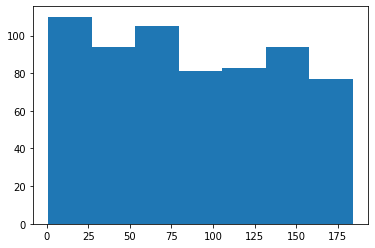

In [8]:
# number of days of data available for failed drives
days = failed_df[['date', 'serial_number', 'failure']].groupby('serial_number').size().compute()
plt.hist(days, bins=7)    # 92 days / 2 weeks = 7 bins

### Downsample Working Drives

In [9]:
# extract mean,std,capacity for working drives
# but first, drop the columns for which it doesnt make sense the "aggregate" values
drop_cols = ['date', 'capacity_bytes', 'failure']

# FIXME: this is a temp fix. ideally, we should remove model column from the clean data for hgst
if MANUFACTURER.lower() != "seagate":
    drop_cols.append("model")
working_feats_df = utils.featurize_ts(df[~df['serial_number'].isin(failed_serials)],
                                      drop_cols=drop_cols,
                                      num_days=True)
working_feats_df.head()

[########################################] | 100% Completed |  1min 11.7s


,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_9_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,...,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,capacity_bytes,num_days
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ71D,1.120956e+08,0.0,3.795581e+08,40377.923077,0.0,0.0,0.0,17.0,0.0,26.318681,...,0.837115,0.0,0.837042,0.0,0.0,0.0,0.0,0.0,3.200729e+11,91
6VDHZ9H9,1.234109e+08,0.0,2.872033e+08,39796.008696,0.0,0.0,0.0,18.0,0.0,27.530435,...,0.772789,0.0,0.772593,0.0,0.0,0.0,0.0,0.0,3.200729e+11,115
6VDHZA4H,1.271050e+08,0.0,3.796565e+08,40328.606742,0.0,0.0,0.0,12.0,0.0,25.404494,...,0.817295,0.0,0.817218,0.0,0.0,0.0,0.0,0.0,3.200729e+11,89
6VDHZAFY,1.205417e+08,0.0,3.796991e+08,40089.560440,0.0,0.0,0.0,8.0,0.0,31.439560,...,0.682824,0.0,0.682735,0.0,0.0,0.0,0.0,0.0,3.200729e+11,91
6VDHZAKY,1.320863e+08,0.0,2.881417e+08,40232.347826,0.0,0.0,0.0,19.0,0.0,27.147826,...,2.258360,0.0,2.258293,0.0,0.0,0.0,0.0,0.0,3.200729e+11,115


In [8]:
from sklearn.cluster import SpectralClustering, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

**FIXME** euclidean distance is not a good measure for such a high dimensional data, but even dask spectral clustering runs out of memory so we dont have an option.

**TODO** Try dask kmeans or spectral clustering to get more working serials

#### TODO: kmeans does not reach >350 centers

In [9]:
# apply clustering to get the serial numbers that best represent the working drives
num_working_serials = 5000
# sc = SpectralClustering(n_clusters=num_working_serials, 
#                         affinity=cosine_similarity, 
# #                         n_neighbors=50,
#                         n_jobs=-1)
# sc = SpectralClustering(n_clusters=num_working_serials, n_jobs=-1)
# minikm = MiniBatchKMeans(n_clusters=num_working_serials, max_iter=1e5, batch_size=500)
# working_repr_sers = utils.get_downsampled_working_sers(working_feats_df.compute(), num_working_serials, model=minikm)
working_sers = df[~df['serial_number'].isin(failed_serials)]['serial_number'].unique()
working_repr_sers = working_sers.sample(frac=(num_working_serials/len(working_sers))).compute()

# downsample the dataset
working_df = df[df['serial_number'].isin(working_repr_sers)]
working_df.head()

[########################################] | 100% Completed | 25.7s
[########################################] | 100% Completed | 25.3s
[########################################] | 100% Completed |  0.8s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
8,2018-07-01,ZJV02XWV,1.200014e+13,0.0,53340920.0,0.0,1.717476e+08,1259.0,0.0,-100.0,...,100.0,-100.0,75.0,100.0,25.0,100.0,100.0,100.0,100.0,100.0
20,2018-07-01,ZA13YGBG,8.001563e+12,0.0,158767616.0,0.0,3.104080e+09,13910.0,0.0,0.0,...,100.0,100.0,73.0,95.0,27.0,100.0,100.0,100.0,100.0,100.0
27,2018-07-01,S301NGZV,4.000787e+12,0.0,31363312.0,0.0,8.219142e+07,23424.0,0.0,0.0,...,100.0,100.0,76.0,92.0,24.0,100.0,100.0,100.0,100.0,100.0
46,2018-07-01,Z305AJF7,4.000787e+12,0.0,5959552.0,0.0,7.817990e+07,21588.0,0.0,0.0,...,100.0,100.0,81.0,96.0,19.0,100.0,100.0,100.0,100.0,100.0
50,2018-07-01,ZA10RYBR,8.001563e+12,0.0,37112328.0,0.0,1.575094e+09,17024.0,0.0,0.0,...,100.0,100.0,58.0,100.0,42.0,100.0,100.0,100.0,100.0,100.0


### Combine Failed and Working Drives
Even the combined data should be small enough since we have downsampled significantly. Therefore bring the combined df in memory so it is easier to work with

In [10]:
# concatenate rows
df = failed_df.append(working_df)

# drop columns that wont be useful for prediction
if MANUFACTURER == "hgst":
    df = df.drop('model', axis=1)

df.head()

[########################################] | 100% Completed |  0.8s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
60,2018-07-01,S301GMGW,4.000787e+12,0.0,171832640.0,0.0,6.912202e+07,25241.0,0.0,0.0,...,100.0,100.0,78.0,63.0,22.0,100.0,100.0,100.0,100.0,100.0
243,2018-07-01,Z304KR3C,4.000787e+12,0.0,230540768.0,0.0,2.555230e+08,23960.0,0.0,0.0,...,100.0,100.0,81.0,98.0,19.0,100.0,100.0,100.0,100.0,100.0
613,2018-07-01,ZCH0CDHJ,1.200014e+13,0.0,125181424.0,0.0,2.146338e+08,2901.0,0.0,-100.0,...,100.0,-100.0,71.0,100.0,29.0,100.0,100.0,100.0,100.0,100.0
840,2018-07-01,ZA171RYT,8.001563e+12,0.0,116709632.0,56.0,2.516390e+09,10216.0,0.0,0.0,...,100.0,100.0,77.0,94.0,23.0,100.0,100.0,100.0,100.0,100.0
1144,2018-07-01,ZCH07J8T,1.200014e+13,0.0,182899248.0,0.0,7.768506e+08,5908.0,0.0,-100.0,...,100.0,-100.0,66.0,100.0,34.0,100.0,100.0,100.0,100.0,100.0


### Add RUL column
**NOTE**: RUL values make sense only for the failed drives, because they have been observed to fail. For working drives, actual failure time is unknown and therefore RUL values are not meaningful. For the purposes of this notebook, RUL is used only as a tool for processing/labelling data 

In [11]:
# convert from str to datetime
df['date'] = df['date'].astype('datetime64')

# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
df = df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [16]:
df.head()

[########################################] | 100% Completed | 33.0s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days
0,2018-08-09,S300YQX2,4.000787e+12,0.0,50260496.0,0.0,402681536.0,27395.0,0.0,0.0,...,100.0,82.0,84.0,18.0,100.0,100.0,100.0,100.0,100.0,144 days
1,2018-08-10,S300YQX2,4.000787e+12,0.0,42453640.0,0.0,403738272.0,27419.0,0.0,0.0,...,100.0,82.0,84.0,18.0,100.0,100.0,100.0,100.0,100.0,143 days
2,2018-08-11,S300YQX2,4.000787e+12,0.0,11831192.0,0.0,405540256.0,27443.0,0.0,0.0,...,100.0,82.0,84.0,18.0,100.0,100.0,100.0,100.0,100.0,142 days
3,2018-08-12,S300YQX2,4.000787e+12,0.0,47472400.0,0.0,406959968.0,27467.0,0.0,0.0,...,100.0,81.0,84.0,19.0,100.0,100.0,100.0,100.0,100.0,141 days
4,2018-08-13,S300YQX2,4.000787e+12,0.0,203304240.0,0.0,407559328.0,27491.0,0.0,0.0,...,100.0,81.0,84.0,19.0,100.0,100.0,100.0,100.0,100.0,140 days


## Create Rolling Aggregates
Instead of having raw values in rows, use rolling aggregates of those values. This is closer to the setup we will have during inference time. Also, this will provide more data points because there will be multiple data points for a single hard drive.

It turns out that almost all the values being used as features are already simple rolling counts, and not instantaneous counts. The only instantaneous features are temperature related.

## Add Multiclass Labels
All data points will be treated as unique data points. Labels will be added according to rul. The numerical representation of labels are as follows:
1. 0 = good
2. 1 = warning
3. 2 = bad

In [12]:
# remove working drive data that is recorded after [quarter end minus 6 weeks]
# because we dont know (as of quarter end) if those drives survived more than 6 weeks or not
df = df[(df['serial_number'].isin(failed_serials)) | (df['rul_days'] >= WARNING_THRESHOLD_NDAYS)]
print(dd.compute(df.shape))

[########################################] | 100% Completed | 42.1s
((669476, 39),)


In [13]:
# NOTE: assignment must be done in th
# df.head()is order otherwise it wont be correct. FIXME
# assign all as good initially
df['status'] = 0

# overwrite those which have rul less than 6 weeks as warning
df['status'] = df['status'].mask(df['rul_days'] < WARNING_THRESHOLD_NDAYS, 1)

# overwrite those which have rul less than 2 weeks as bad
df['status'] = df['status'].mask(df['rul_days'] < BAD_THRESHOLD_NDAYS, 2)

In [14]:
df.head()

[########################################] | 100% Completed | 29.4s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days,status
0,2018-08-09,S300X3ZR,4.000787e+12,0.0,96868704.0,0.0,127312976.0,31228.0,0.0,0.0,...,78.0,74.0,22.0,100.0,100.0,100.0,100.0,100.0,144 days,0
1,2018-08-10,S300X3ZR,4.000787e+12,0.0,116871608.0,0.0,127848144.0,31252.0,0.0,0.0,...,78.0,74.0,22.0,100.0,100.0,100.0,100.0,100.0,143 days,0
2,2018-08-11,S300X3ZR,4.000787e+12,0.0,205206688.0,0.0,128310592.0,31276.0,0.0,0.0,...,78.0,74.0,22.0,100.0,100.0,100.0,100.0,100.0,142 days,0
3,2018-08-12,S300X3ZR,4.000787e+12,0.0,42628720.0,0.0,128774160.0,31300.0,0.0,0.0,...,77.0,74.0,23.0,100.0,100.0,100.0,100.0,100.0,141 days,0
4,2018-08-13,S300X3ZR,4.000787e+12,0.0,140203584.0,0.0,129248848.0,31324.0,0.0,0.0,...,78.0,74.0,22.0,100.0,100.0,100.0,100.0,100.0,140 days,0


## Add diffs

**NOTE** The following 3-4 cells show how the differentials from the previous 6 days, along with the rate of change, can be added as features to the dataframe. Initial experiments showed that this does not add much value for inference, and instead we will be generating some other features. But I will leave this here (but NOT run it) for experimentation purposes.

In [67]:
# columns for which diffs must be calculated
diff_cols = [col for col in df.columns if col.lower().startswith('smart')]

In [93]:
def add_deltas(group):
    # FIXME: workaround for passing diff_cols as parameter
    global diff_cols
    for colname in diff_cols:
        # add rate of change
        roc_colname = "d_" + colname
        group[roc_colname] = (group[colname] - group[colname].shift(1)).fillna(method='bfill')
        # add rate of rate of change
        roroc_colname = "d2_" + colname
        group[roroc_colname] = (group[roc_colname] - group[roc_colname].shift(1)).fillna(method='bfill')
    return group

In [95]:
# # =============================== FOR DASK =============================== #
# # create meta of the resulting failed_df otherwise dask complains
# rul_meta = df._meta
# rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# # ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
df = df.groupby('serial_number').apply(add_deltas).reset_index(drop=True)

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  if __name__ == '__main__':


**FIXME** For now, just drop the cols that are nans (v v small fraction). in the future, would need an intelligent way of doing this

In [150]:
# dcols = [col for col in df.columns if ((col.lower().startswith('d_')) or (col.lower().startswith('d2_')))]
# X_train.drop(dcols, axis=1).isna().any().any()    # False. this means nans arise from diffs
df = df.fillna(0)
df.isna().any().compute()

[########################################] | 100% Completed |  2min  2.6s


date                       False
serial_number              False
capacity_bytes             False
failure                    False
smart_1_raw                False
                           ...  
d2_smart_240_normalized    False
d_smart_241_normalized     False
d2_smart_241_normalized    False
d_smart_242_normalized     False
d2_smart_242_normalized    False
Length: 108, dtype: bool

In [151]:
dd.compute(df.shape)

[########################################] | 100% Completed |  2min  3.9s


((110281, 108),)

## Add Features: 6 days rolling mean, std, coefficient of variation

The following function is an experimental version of the `featurize_df` function. It **REQUIRES** indices to be unique (and thus wont work with dask).

In [15]:
def pandas_rolling_feats(df, window=6, drop_cols=('date', 'failure', 'capacity_bytes', 'rul'), group_cols=('serial_number'), cap=True):
    # save the status labels
    statuses = df['status']

    # group by serials, drop cols which are not to be aggregated
    if drop_cols is not None:
        grouped_df = df.drop(drop_cols, axis=1).groupby(group_cols)
    else:
        grouped_df = df.groupby(group_cols)
        
    # feature columns
    featcols = grouped_df.first().columns
    
    # get mean value in last 6 days
    means = grouped_df.rolling(window)[featcols].mean()
    
    # get std in last 6 days
    stds = grouped_df.rolling(window)[featcols].std()
    
    # coefficient of variation
    cvs = stds.divide(means, fill_value=0)

    # rename before mergeing
    means = means.rename(columns={col: 'mean_' + col for col in means.columns})
    stds = stds.rename(columns={col: 'std_' + col for col in stds.columns})
    cvs = cvs.rename(columns={col: 'cv_' + col for col in cvs.columns})
    
    # combine features into one df
    res = means.merge(stds, left_index=True, right_index=True)
    res = res.merge(cvs, left_index=True, right_index=True)
    
    # drop rows where all columns are nans
    res = res.dropna(how='all')
    
    # fill nans created by cv calculation
    res = res.fillna(0)
    
    # capacity of hard drive
    if cap:
        capacities = df[['serial_number', 'capacity_bytes']].groupby('serial_number').max()
        res = res.merge(capacities, left_index=True, right_index=True)
        
    # bring serial number back as a col instead of index, preserve the corresponding indices
    res = res.reset_index(level=[0])
    
    # add status labels back.
    res = res.merge(statuses, left_index=True, right_index=True)
    
    return res

In [16]:
# must convert dask to pandas
df = df.compute()

# MUST make sure indices are unique before processing
df = df.reset_index(drop=True)
feats_df = pandas_rolling_feats(df,
                                window=6,
                                drop_cols=['date', 'capacity_bytes', 'failure', 'rul_days', 'status'],
                                group_cols=['serial_number'])

[########################################] | 100% Completed | 41.8s


In [17]:
# infinities get added to df - remove these
feats_df = feats_df.replace([np.inf, -np.inf], np.nan).dropna()
feats_df.head()

,serial_number,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_9_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,...,cv_smart_190_normalized,cv_smart_193_normalized,cv_smart_194_normalized,cv_smart_197_normalized,cv_smart_198_normalized,cv_smart_240_normalized,cv_smart_241_normalized,cv_smart_242_normalized,capacity_bytes,status
401298,S2ZYJ9AF511164,308.0,0.0,0.0,27845.0,0.0,-100.0,0.078777,70935512.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,5.001079e+11,1
401299,S2ZYJ9AF511164,308.0,0.0,0.0,27845.0,0.0,-100.0,0.078777,70935512.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,5.001079e+11,1
401300,S2ZYJ9AF511164,308.0,0.0,0.0,27845.0,0.0,-100.0,0.078777,70935512.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,5.001079e+11,1
401301,S2ZYJ9AF511164,308.0,0.0,0.0,27845.0,0.0,-100.0,0.078777,70935512.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,5.001079e+11,1
401302,S2ZYJ9AF511164,308.0,0.0,0.0,27845.0,0.0,-100.0,0.078777,70935512.0,-100.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,5.001079e+11,0


## Drive-wise Split Data

In [18]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from dask_ml.preprocessing import RobustScaler as ddRobustScaler
from dask_ml.preprocessing import StandardScaler as ddStandardScaler
from dask_ml.model_selection import train_test_split as ddtrain_test_split

In [19]:
# ['date', 'serial_number', 'model', 'failure', 'rul_days', 'status']
# ['serial_number', 'status']
X_arr = feats_df.drop(['serial_number', 'status'], axis=1)
Y_arr = feats_df[['serial_number', 'status']]

In [20]:
# failed serials left after reduction
failed_sers_red = pd.Series(Y_arr['serial_number'].unique())
failed_sers_red = failed_sers_red[failed_sers_red.isin(failed_serials)]

# working serials left after reduction
working_sers_red = pd.Series(Y_arr['serial_number'].unique())
working_sers_red = working_sers_red[~working_sers_red.isin(failed_serials)]

# split working and failed
working_train, working_test = train_test_split(working_sers_red, test_size=0.2, random_state=42)
failed_train, failed_test = train_test_split(failed_sers_red, test_size=0.2, random_state=42)

In [21]:
# use serial numbers to generate train/test set
# CHECKED OK - train/test ratio 0.8, fail/work and overall both
X_train_work = X_arr[Y_arr['serial_number'].isin(working_train)]
X_train_fail = X_arr[Y_arr['serial_number'].isin(failed_train)]
X_train = pd.concat([X_train_work, X_train_fail])

Y_train_work = Y_arr[Y_arr['serial_number'].isin(working_train)]['status']
Y_train_fail = Y_arr[Y_arr['serial_number'].isin(failed_train)]['status']
Y_train = pd.concat([Y_train_work, Y_train_fail])

X_test_work = X_arr[Y_arr['serial_number'].isin(working_test)]
X_test_fail = X_arr[Y_arr['serial_number'].isin(failed_test)]
X_test = pd.concat([X_test_work, X_test_fail])

Y_test_work = Y_arr[Y_arr['serial_number'].isin(working_test)]['status']
Y_test_fail = Y_arr[Y_arr['serial_number'].isin(failed_test)]['status']
Y_test = pd.concat([Y_test_work, Y_test_fail])

In [22]:
# verufy proportions
print(X_train_fail.shape)
print(X_test_fail.shape)
print(X_train_work.shape)
print(X_test_work.shape)

(42373, 103)
(10108, 103)
(472593, 103)
(117458, 103)


## Scale

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [24]:
# robust scaling to not be outlier sensitive
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [25]:
# FIXME: this would not work for dask objects (delayed objects) - MUST use cloudpickle for that
fname = '../models/{}_preprocessor_{}.joblib'.format(MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S"))
joblib.dump(scaler, fname)

['../models/seagate_preprocessor_Sep_03_2019_13_14_49.joblib']

## Establish Baseline

What would a baseline multiclass classifier look like? This can be found using a naive approach where drives are classified purely based on predefined/inferred thresholds.

Thresholds can be set in a variety of ways. A simple and naive way would be to involve all the covariates to determine the threshold boundary using their mean, or std, or max, or min values. Then, based some distance metric, drive can be classified.

In [40]:
# use mean values as threshold
class0_mean = X_train[(Y_train==0).values, :].mean(axis=0, keepdims=True)
class1_mean = X_train[(Y_train==1).values, :].mean(axis=0, keepdims=True)
class2_mean = X_train[(Y_train==2).values, :].mean(axis=0, keepdims=True)
class_means = np.vstack((class0_mean, class1_mean, class2_mean))

# predict based on a distance metric from mean values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(scaler.transform(X_test), class_means, metric='canberra')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[26593, 55425, 40595],
       [  625,  1091,  1041],
       [  285,   635,   669]])

array([[0.21688565, 0.452032  , 0.33108235],
       [0.22669568, 0.39571999, 0.37758433],
       [0.17935809, 0.3996224 , 0.42101951]])

In [41]:
# use median values as threshold
class0_median = np.median(X_train[(Y_train==0).values, :], axis=0, keepdims=True)
class1_median = np.median(X_train[(Y_train==1).values, :], axis=0, keepdims=True)
class2_median = np.median(X_train[(Y_train==2).values, :], axis=0, keepdims=True)
class_medians = np.vstack((class0_median, class1_median, class2_median))

# predict based on a distance metric from median values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(scaler.transform(X_test), class_medians, metric='canberra')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[  2185,  16991, 103437],
       [    51,    335,   2371],
       [    14,    187,   1388]])

array([[0.0178203 , 0.13857421, 0.84360549],
       [0.01849837, 0.12150889, 0.85999275],
       [0.00881057, 0.11768408, 0.87350535]])

In [42]:
# use min values as threshold
class0_min = X_train[(Y_train==0).values, :].min(axis=0, keepdims=True)
class1_min = X_train[(Y_train==1).values, :].min(axis=0, keepdims=True)
class2_min = X_train[(Y_train==2).values, :].min(axis=0, keepdims=True)
class_mins = np.vstack((class0_min, class1_min, class2_min))

# predict based on a distance metric from min values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(scaler.transform(X_test), class_mins, metric='cosine')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[40628, 25678, 56307],
       [  732,   842,  1183],
       [  504,   551,   534]])

array([[0.33135149, 0.20942314, 0.45922537],
       [0.26550598, 0.30540443, 0.42908959],
       [0.31718062, 0.34675897, 0.33606042]])

In [43]:
# use max values as threshold
class0_max = X_train[(Y_train==0).values, :].max(axis=0, keepdims=True)
class1_max = X_train[(Y_train==1).values, :].max(axis=0, keepdims=True)
class2_max = X_train[(Y_train==2).values, :].max(axis=0, keepdims=True)
class_maxs = np.vstack((class0_max, class1_max, class2_max))

# predict based on a distance metric from max values
# NOTE: canberra, cosine generally work better than l2,l1,etc
# preds = pairwise_distances_argmin(X_test, class_maxs, metric='cosine')
class0_confs = (scaler.transform(X_test) > class0_max).sum(axis=1, keepdims=True)
class1_confs = (scaler.transform(X_test) > class1_max).sum(axis=1, keepdims=True)
class2_confs = (scaler.transform(X_test) > class2_max).sum(axis=1, keepdims=True)
class_confs = np.hstack((class0_confs, class1_confs, class2_confs))
preds = np.argmax(class_confs, axis=1)

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[120093,   1826,    694],
       [  2715,     31,     11],
       [  1524,     55,     10]])

array([[0.97944753, 0.01489238, 0.00566008],
       [0.98476605, 0.01124411, 0.00398984],
       [0.95909377, 0.03461296, 0.00629327]])

## Train

**NOTE** As of today (September 3, 2019) it is difficult to integrate into Ceph models built using python libraries that are not rpm or deb packaged.  
Therefore RGF and XGBoost just serve as comparisons as opposed to models that can be actually used in upstream Ceph today

In [26]:
# training is going to require a lot of memory. free as much as possible
del df
del feats_df
del X_train_work
del X_train_fail
del Y_train_work
del Y_train_fail
del X_test_work
del X_test_fail
del Y_test_work
del Y_test_fail
gc.collect()

182

### Vanilla Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [28]:
# with joblib.parallel_backend('dask'):
dt_clf = DecisionTreeClassifier(random_state=24)
dt_clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=24, splitter='best')

In [29]:
# with joblib.parallel_backend('dask'):
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(dt_confmat)
print(classification_report(Y_test, dt_preds, target_names=['good', 'warning', 'bad']))

[[119369   1797   2068]
 [  2137    272    343]
 [  1007    222    351]]
              precision    recall  f1-score   support

        good       0.97      0.97      0.97    123234
     warning       0.12      0.10      0.11      2752
         bad       0.13      0.22      0.16      1580

    accuracy                           0.94    127566
   macro avg       0.41      0.43      0.41    127566
weighted avg       0.95      0.94      0.94    127566



In [30]:
# FIXME: this would not work for dask objects (delayed objects) - MUST use cloudpickle for that
fname = '../models/{}_predictor_dt_{}.joblib'.format(MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S"))
joblib.dump(dt_clf, fname)

['../models/seagate_predictor_dt_Sep_03_2019_13_15_26.joblib']

### Vanilla Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf_clf = RandomForestClassifier(n_estimators=12, class_weight='balanced', n_jobs=-1, random_state=24)
rf_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=12, n_jobs=-1, oob_score=False,
                       random_state=24, verbose=0, warm_start=False)

In [33]:
# get preds
rf_preds = rf_clf.predict(scaler.transform(X_test))
rf_confmat = confusion_matrix(Y_test, rf_preds)

print(rf_confmat)
print(classification_report(Y_test, rf_preds, target_names=['good', 'warning', 'bad']))

[[122948    174    112]
 [  2545     87    120]
 [  1290     62    228]]
              precision    recall  f1-score   support

        good       0.97      1.00      0.98    123234
     warning       0.27      0.03      0.06      2752
         bad       0.50      0.14      0.22      1580

    accuracy                           0.97    127566
   macro avg       0.58      0.39      0.42    127566
weighted avg       0.95      0.97      0.95    127566



In [34]:
# FIXME: this would not work for dask objects (delayed objects) - MUST use cloudpickle for that
fname = '../models/{}_predictor_rf_{}.joblib'.format(MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S"))
joblib.dump(dt_clf, fname)

['../models/seagate_predictor_rf_Sep_03_2019_13_15_34.joblib']

### SVM

In [74]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train)

In [ ]:
# get preds
svc_preds = svc.predict(scaler.transform(X_test))
svc_confmat = confusion_matrix(Y_test, svc_preds)

print(svc_confmat)
print(classification_report(Y_test, svc_preds, target_names=['good', 'warning', 'bad']))

### MLP

In [83]:
from dask_ml.wrappers import Incremental
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 512, 512, 128),
                    activation='sigmoid',
                    batch_size=256,
                    warm_start=True,
                    random_state=24)
# clf = Incremental(mlp)
mlp.fit(X_train, Y_train)

In [ ]:
# with parallel_backend('dask'):
# get preds
mlp_preds = mlp.predict(scaler.transform(X_test))
mlp_confmat = confusion_matrix(Y_test, mlp_preds)

print(np.around(mlp_confmat / mlp_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, mlp_preds, target_names=['good', 'warning', 'bad']))

### RGF (depracated due to dependency issues)

In [ ]:
from rgf.sklearn import RGFClassifier

In [ ]:
# with parallel_backend('dask'):
rgf_clf = RGFClassifier(max_leaf=2500, l2=1e-12, learning_rate=0.01)
rgf_clf.fit(X_train, Y_train)

In [ ]:
# get preds
rgf_preds = rgf_clf.predict(scaler.transform(X_test))
rgf_confmat = confusion_matrix(Y_test, rgf_preds)

print(np.around(rgf_confmat / rgf_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, rgf_preds, target_names=['good', 'warning', 'bad']))

### XGBoost (depracated due to dependency issues)

In [78]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(max_depth=8, n_jobs=8)
xgb_clf.fit(X_train, Y_train)

In [ ]:
# get preds
xgb_preds = xgb_clf.predict(scaler.transform(X_test))
xgb_confmat = confusion_matrix(Y_test, xgb_preds)

print(np.around(xgb_confmat / xgb_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, xgb_preds, target_names=['good', 'warning', 'bad']))